In [1]:
%matplotlib inline 
 
# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union
from pathlib import Path
import time
import io
import contextlib
import json

import torch
import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm
import h5py

from copy import deepcopy
from typing import Callable, List, Dict, Tuple, Optional
from pprint import pprint
from PIL import Image

import shap
from captum.attr import IntegratedGradients

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from IPython.display import clear_output, display


In [3]:
# import test windows from metadata

m = json.load(open("trainings/X_windows_meta.json"))

X_windows = np.memmap(m["X_path"], mode="r", dtype=np.dtype(m["X_dtype"]), shape=tuple(m["X_shape"]))
y_windows = np.memmap(m["y_path"], mode="r", dtype=np.dtype(m["y_dtype"]), shape=tuple(m["y_shape"]))
kept_final_feats = m["features"]

print(kept_final_feats)

['volume', 'trade_count', 'ret', 'sma_pct_5', 'sma_pct_9', 'sma_pct_21', 'sma_pct_50', 'sma_pct_100', 'sma_pct_200', 'roc_5', 'roc_10', 'roc_21', 'body_pct', 'upper_shad', 'lower_shad', 'range_pct', 'rsi_6', 'rsi_14', 'rsi_21', 'atr_pct_7', 'atr_pct_14', 'atr_pct_28', 'plus_di_7', 'minus_di_7', 'adx_7', 'plus_di_14', 'minus_di_14', 'adx_14', 'plus_di_28', 'minus_di_28', 'adx_28', 'bb_w_20_2p0', 'bb_w_50_2p0', 'vol_spike_7', 'vol_spike_14', 'vol_spike_28', 'dist_high_200', 'dist_low_200', 'obv_diff_7', 'obv_pct_7', 'obv_diff_21', 'obv_pct_21', 'ret_std_21', 'ret_std_63', 'stoch_k_14_3_3', 'stoch_d_14_3_3', 'stoch_k_9_3_3', 'stoch_d_9_3_3', 'cci_14', 'cci_20', 'mfi_14', 'mfi_20', 'cmf_14', 'cmf_20', 'donch_w_20', 'donch_w_55', 'kc_w_20_20_1.5', 'vwap_RZ', 'sma_5_RZ', 'sma_9_RZ', 'sma_21_RZ', 'sma_50_RZ', 'sma_100_RZ', 'sma_200_RZ', 'ema_3_RZ', 'ema_5_RZ', 'ema_8_RZ', 'ema_9_RZ', 'ema_13_RZ', 'ema_21_RZ', 'ema_50_RZ', 'macd_line_6_13_5_RZ', 'macd_signal_6_13_5_RZ', 'macd_diff_6_13_5_RZ', 


Hyperparameters:
{'ALPHA_SMOOTH': 0,
 'CLIPNORM': 2,
 'CONV_CHANNELS': 64,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'DROPOUT_TRANS': 0.03,
 'EARLY_STOP_PATIENCE': 9,
 'FLATTEN_MODE': 'attn',
 'HEAD_LR_PCT': 1,
 'HUBER_DELTA': 0.1,
 'LAMBDA_DELTA': 0.1,
 'LONG_UNITS': 64,
 'LOOK_BACK': 60,
 'MAX_EPOCHS': 90,
 'MICRO_SAMPLE_K': 16,
 'ONECYCLE_DIV_FACTOR': 10,
 'ONECYCLE_FINAL_DIV': 100,
 'ONECYCLE_MAX_LR': 0.0002,
 'ONECYCLE_PCT_START': 0.1,
 'ONECYCLE_STRATEGY': 'cos',
 'PRED_HIDDEN': 96,
 'SHORT_UNITS': 64,
 'TCN_CHANNELS': 64,
 'TCN_KERNEL': 3,
 'TCN_LAYERS': 1,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 4,
 'TRAIN_WORKERS': 8,
 'TRANSFORMER_D_MODEL': 64,
 'TRANSFORMER_FF_MULT': 4,
 'TRANSFORMER_HEADS': 4,
 'TRANSFORMER_LAYERS': 2,
 'USE_CONV': False,
 'USE_DELTA': False,
 'USE_HUBER': False,
 'USE_LONG_LSTM': False,
 'USE_SHORT_LSTM': False,
 'USE_TCN': False,
 'USE_TRANSFORMER': True,
 'VAL_BATCH': 1,
 'WARMUP_STEPS': 3,
 'WEIGHT_DECAY': 2

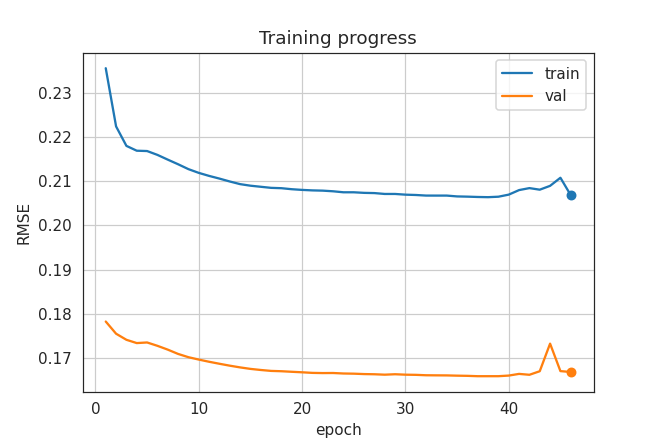


Train metrics: {'rmse': 0.20682313257495788, 'mae': 0.11467189083039683, 'r2': 0.20550709069818174}
 Val metrics: {'rmse': 0.16689909134599168, 'mae': 0.09629229247100225, 'r2': 0.179089986068791}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


RuntimeError: Error(s) in loading state_dict for ModelClass:
	size mismatch for pos_enc.pe: copying a param with shape torch.Size([1, 30, 64]) from checkpoint, the shape in current model is torch.Size([1, 60, 64]).

In [4]:
####################### MODEL RELOADING ####################

fname = f"{params.ticker}_{params.sel_val_rmse}_all.pth"
model_path = Path(params.models_folder) / fname

ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

print("\nHyperparameters:")
pprint(ckpt["hparams"])

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model = models_custom.ModelClass(
    n_feats             = len(kept_final_feats),
    short_units         = ckpt["hparams"]["SHORT_UNITS"],
    long_units          = ckpt["hparams"]["LONG_UNITS"],
    transformer_d_model = ckpt["hparams"]["TRANSFORMER_D_MODEL"],
    transformer_layers  = ckpt["hparams"]["TRANSFORMER_LAYERS"],
    dropout_short       = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long        = ckpt["hparams"]["DROPOUT_LONG"],
    dropout_trans       = ckpt["hparams"]["DROPOUT_TRANS"],
    pred_hidden         = ckpt["hparams"]["PRED_HIDDEN"],
    look_back           = ckpt["hparams"]["LOOK_BACK"],

    # Gating flags
    use_conv            = ckpt["hparams"]["USE_CONV"],
    use_tcn             = ckpt["hparams"]["USE_TCN"],
    use_short_lstm      = ckpt["hparams"]["USE_SHORT_LSTM"],
    use_transformer     = ckpt["hparams"]["USE_TRANSFORMER"],
    use_long_lstm       = ckpt["hparams"]["USE_LONG_LSTM"],
    use_delta           = ckpt["hparams"]["USE_DELTA"],
    flatten_mode        = ckpt["hparams"]["FLATTEN_MODE"]
)

# Load *only* the weight tensors into that fresh model
model.load_state_dict(ckpt["model_state_dict"])

model.to(params.device)
model.eval()

print("Loaded checkpoint:", ckpt)



In [ ]:
# Prepare master dict for feature importances
features_importances = {feat: {} for feat in kept_final_feats}
target_name = 'targ_signal'

In [ ]:
def corr_importance(X_windows, y_windows, feature_names,
                                n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Compute model-level Pearson correlation importance for a trained transformer.

    Returns:
    - pd.Series: absolute Pearson correlation per feature (higher = more important)
    - base_mse: None (no baseline MSE for this univariate data method)
    """
    
    # flatten features across samples and timesteps: shape (N*L, F)
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_rep = np.repeat(y_windows, L)

    # compute absolute Pearson per feature (handle constant cols)
    scores = {}
    for fi, fname in enumerate(feature_names):
        col = X_flat[:, fi]
        if np.all(col == col[0]):
            corr_val = 0.0
        else:
            corr_val = np.corrcoef(col, y_rep)[0, 1]
            if np.isnan(corr_val):
                corr_val = 0.0
        scores[fname] = float(abs(corr_val))

    # build final series (sorted desc) and display using shared helper
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # use your common live display helper to reveal results consistently
    # reveal in original feature order (pass feature_names) or ranked order (imp_series.index.tolist())
    _ = feats.live_display_importances(imp_series, features=feature_names, target=target_name, method="Corr", batch=4, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_corr, _ = corr_importance(X_windows, y_windows, kept_final_feats,
                                         n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="corr", values=imp_corr)
print(list(imp_corr.index)[:70])

In [ ]:

def mi_importance(X_windows, y_windows, feature_names,
                              n_repeats=1, batch_size=1024, seed=0, device=params.device,
                              sample_size=50000, batch_feat_size=32, mi_n_neighbors=5, n_jobs=-1):
    """
    Faster but slightly more precise mutual information importance.

    Same signature as before plus optional tuning params:
    - sample_size: max rows (N*L) to sample for MI estimation (int or None for full)
    - batch_feat_size: number of features per vectorized MI call
    - mi_n_neighbors: number of neighbors passed to mutual_info_regression
    - n_jobs: parallel jobs for mutual_info_regression (-1 uses all cores if supported)

    Returns: (pd.Series sorted desc, None) and updates features_importances like other functions.
    """

    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    total_rows = X_flat.shape[0]
    scores_acc = np.zeros(F, dtype=float)
    runs = 2  # average two subsample runs (seed, seed+1)

    for run in range(runs):
        run_seed = seed + run
        if sample_size is not None and total_rows > sample_size:
            idx = rng.choice(total_rows, size=sample_size, replace=False)
            X_sub = X_flat[idx, :]
            y_sub = y_flat[idx]
        else:
            X_sub = X_flat
            y_sub = y_flat

        const_mask = np.all(X_sub == X_sub[:1, :], axis=0)

        for start in range(0, F, batch_feat_size):
            cols = list(range(start, min(F, start + batch_feat_size)))
            nonconst = [c for c in cols if not const_mask[c]]
            if nonconst:
                try:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub,
                                                     random_state=run_seed,
                                                     n_neighbors=mi_n_neighbors,
                                                     n_jobs=n_jobs)
                except TypeError:
                    mi_vals = mutual_info_regression(X_sub[:, nonconst], y_sub, random_state=run_seed)
                j = 0
                for c in cols:
                    if const_mask[c]:
                        scores_acc[c] += 0.0
                    else:
                        scores_acc[c] += float(mi_vals[j]); j += 1
            else:
                for c in cols:
                    scores_acc[c] += 0.0

        # light pause to let UI breathe between subsample runs
        time.sleep(0.01)

        # partial display using the shared helper (reveals current averaged values)
        partial_series = pd.Series(scores_acc / (run + 1), index=feature_names).sort_values(ascending=False)
        # reveal in original feature order; batch controls update granularity
        _ = feats.live_display_importances(partial_series, features=feature_names, target=target_name, method=f"MI (run {run+1}/{runs})", batch=16, pause=0.01)

    mi_avg = scores_acc / runs
    imp_series = pd.Series({feature_names[i]: float(mi_avg[i]) for i in range(F)}).sort_values(ascending=False)
    # final reveal (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), target=target_name, method="MI", batch=8, pause=0.02)

    return imp_series, None


##########################################################################################################################################

imp_mi, _ = mi_importance(X_windows, y_windows, kept_final_feats,
                                      n_repeats=1, batch_size=1024, seed=0, device=params.device)

feats.update_feature_importances(features_importances, importance_type="mi", values=imp_mi)
print(list(imp_mi.index)[:70])

In [ ]:

def linreg_coef_importance(X_windows, y_windows, feature_names,
                                       n_repeats=1, batch_size=1024, seed=0, device=params.device):
    """
    Importance from absolute standardized coefficients of a Ridge linear model
    trained on flattened (sample x time) features.

    - Fits a Ridge regression on X_flat (shape N*L, F) -> y_rep (N*L,)
    - Standardizes features before fitting (zero mean, unit std)
    - Uses absolute value of coefficients as importance
    Returns (pd.Series sorted desc, None) and does not change the torch model.
    """

    # prepare flattened data
    N, L, F = X_windows.shape
    assert F == len(feature_names), "feature_names length must match X_windows feature axis"
    X_flat = X_windows.reshape(N * L, F)
    y_flat = np.repeat(y_windows, L)

    # quick initial placeholder so UI shows immediate feedback
    clear_output(wait=True)
    display_text = pd.Series({"status": "Starting linreg importance..."})
    # use live_display_importances to show placeholder (it expects a Series indexed by features)
    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, target=target_name, method="LinReg (starting)", batch= max(1, F//10), pause=0.01)

    # standardize features only on a small subsample to avoid allocating full X_std
    scaler = StandardScaler()
    rng = np.random.RandomState(seed)
    subsample_size = min(20000, X_flat.shape[0])
    if X_flat.shape[0] > subsample_size:
        subs_idx = rng.choice(X_flat.shape[0], size=subsample_size, replace=False)
        X_sub_raw = X_flat[subs_idx]
        scaler.fit(X_sub_raw)
        X_sub = scaler.transform(X_sub_raw)
        y_sub = y_flat[subs_idx]
    else:
        X_sub = scaler.fit_transform(X_flat)
        y_sub = y_flat
    
    # free the full flattened array early
    del X_flat
    gc.collect()

    alphas = np.logspace(-3, 3, 13)
    # use RidgeCV but run on subsample
    ridge_cv = RidgeCV(alphas=alphas, scoring="neg_mean_squared_error")
    ridge_cv.fit(X_sub, y_sub)
    best_alpha = float(ridge_cv.alpha_)

    # intermediate reveal after alpha selection (show small text via live_display_importances)
    mid_placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    # annotate best alpha by temporarily setting the first feature to a nonzero small value so UI shows progress textually
    mid_placeholder.iloc[0] = 0.001
    _ = feats.live_display_importances(mid_placeholder, features=feature_names, target=f"{target_name} (alpha={best_alpha:.3g})", method="LinReg (alpha selected)", batch=max(1, F//10), pause=0.01)
    time.sleep(0.01)
    
    # fit final Ridge on standardized data with chosen alpha (fast)
    ridge = Ridge(alpha=best_alpha, solver="auto")
    ridge.fit(X_sub, y_sub)
    coefs = ridge.coef_.flatten() if hasattr(ridge, "coef_") else np.asarray([0.0] * F)
    coefs = np.asarray(coefs).reshape(-1)[:F]

    # importance = absolute standardized coefficient
    scores = {feature_names[i]: float(abs(coefs[i])) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal using live_display_importances (ranked)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), target=target_name, method="LinReg", batch=max(1, len(imp_series)//10), pause=0.02)

    return imp_series, None


##############################################################################################################################################


imp_linreg, _ = linreg_coef_importance(
    X_windows, y_windows, kept_final_feats,
    batch_size=1024, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="linreg", values=imp_linreg)
print(list(imp_linreg.index)[:70])

In [ ]:
def ablation_importance(model, X_windows, y_windows, feature_names,
                        batch_size=1024, predict_batch=512, seed=0, device=params.device,
                        chunk_size=32, plot=True):
    """
    Exact ablation ΔMSE (no approximation), memory-safe:
    - computes base_mse on full set
    - processes features in chunks, but streams predictions over sample minibatches
      to avoid allocating k * N full copies
    - returns (pd.Series ΔMSE per feature, base_mse)
    """
    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    was_training = model.training
    model.to(device); model.eval()
    with torch.no_grad():
        base_pred = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse = float(mean_squared_error(y_windows, base_pred))

    X_windows = X_windows.astype(np.float32)
    y_windows = y_windows.astype(np.float32)
    feat_means = X_windows.reshape(N * L, F).mean(axis=0).astype(np.float32)

    scores = np.zeros(F, dtype=float)

    # process features in chunks but stream over sample minibatches
    with torch.no_grad():
        for start in range(0, F, chunk_size):
            end = min(F, start + chunk_size)
            k = end - start
            se_sums = np.zeros(k, dtype=float)   # sum of squared errors per ablation across all samples
            total = 0

            # stream over sample minibatches to keep memory small
            for s in range(0, N, predict_batch):
                s2 = min(N, s + predict_batch)
                Xb = X_windows[s:s2]        # (B, L, F)
                yb = y_windows[s:s2]        # (B,)

                # build k small ablated copies for this minibatch: shape (k, B, L, F)
                batch = np.repeat(Xb[None, ...], k, axis=0)
                for i, fi in enumerate(range(start, end)):
                    batch[i, :, :, fi] = float(feat_means[fi])
                
                batch_reshaped = batch.reshape(-1, L, F)
                preds = feats.predict_windows(model, batch_reshaped, batch_size=batch_size, device=device)
                preds = np.asarray(preds).reshape(k, s2 - s)

                # accumulate sum of squared errors per ablation
                se_sums += np.sum((preds - yb[None, :])**2, axis=1)
                total += (s2 - s)

            # compute MSE per ablation on full set and store delta
            mses = se_sums / float(total)
            scores[start:end] = mses - base_mse

            if plot:
                partial = pd.Series({f: float(scores[i]) for i, f in enumerate(feature_names)})
                partial = partial.sort_values(ascending=False)
                _ = feats.live_display_importances(partial, features=feature_names,
                                                   target=target_name, method="Ablation", batch=8, pause=0.02)

    if was_training:
        model.train()

    imp_series = pd.Series({f: float(scores[i]) for i, f in enumerate(feature_names)}).sort_values(ascending=False)
    if plot:
        _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                           target=target_name, method="Ablation", batch=8, pause=0.02)
    return imp_series, base_mse



##########################################################################################################################################


imp_abl, baseline_mse = ablation_importance(
    model, X_windows, y_windows, kept_final_feats,
    batch_size=1024, seed=0, device=params.device
)

print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="ablation", values=imp_abl)
print(list(imp_abl.index)[:70])

In [ ]:
def integrated_gradients_importance(model, X_windows, y_windows, feature_names,
                                    n_steps=50, n_samples=1000, baseline="zero",
                                    batch_size=256, seed=0, device=params.device):
    """
    Integrated Gradients aggregated to per-feature importance (compact, efficient).

    - Computes per-sample IG attributions using batched torch computations and fewer allocations.
    - Aggregates mean(|IG|) over samples and timesteps to give per-feature scores.
    - baseline: "zero", "mean", or a numpy array of shape (L, F).
    - Updates features_importances with importance_type="ig" and returns (pd.Series, None).
    """

    rng = np.random.RandomState(seed)

    model.to(device)
    model.eval()

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    n_explain = min(n_samples, N)
    idx_explain = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_explain = X_windows[idx_explain].astype("float32")  # (n_explain, L, F)

    # baseline tensor (L, F)
    if isinstance(baseline, str) and baseline == "zero":
        baseline_w = np.zeros((L, F), dtype=np.float32)
    elif isinstance(baseline, str) and baseline == "mean":
        baseline_w = X_windows.mean(axis=0).astype(np.float32)
    elif isinstance(baseline, np.ndarray):
        baseline_w = baseline.astype(np.float32)
        assert baseline_w.shape == (L, F)
    else:
        baseline_w = np.zeros((L, F), dtype=np.float32)

    baseline_t = torch.from_numpy(baseline_w).to(device)

    def batch_attributions(xb_np):
        # xb_np: (B, L, F) float32 numpy
        B = xb_np.shape[0]
        xb_t = torch.from_numpy(xb_np).to(device)                       # (B, L, F)
        grads_acc = torch.zeros_like(xb_t, device=device)               # accumulate grads on device

        # loop over steps but keep tensors on device to reduce allocations
        for step in range(1, n_steps + 1):
            alpha = step / float(n_steps)
            inp = baseline_t.unsqueeze(0) + alpha * (xb_t - baseline_t.unsqueeze(0))  # (B, L, F)
            inp.requires_grad_(True)
            out = model(inp)
            preds = out[0] if isinstance(out, (tuple, list)) else out
            preds = preds.reshape(preds.shape[0], -1).sum(dim=1)  # per-sample scalar
            preds_sum = preds.sum()                              # scalar
            preds_sum.backward()
            grads_acc += inp.grad.detach()
            inp.grad.zero_()
            del inp, out, preds, preds_sum
        # IG estimate: (input - baseline) * avg_grad
        ig_t = (xb_t - baseline_t.unsqueeze(0)) * (grads_acc / float(n_steps))
        return ig_t.cpu().numpy()  # (B, L, F)

    # compute attributions in batches and show partial updates (memory-safe: no growing list)
    running_sum_feats = np.zeros((F,), dtype=np.float64)  # accumulate sum over samples+timesteps for each feature
    processed = 0
    
    for start in range(0, len(X_explain), batch_size):
        xb = X_explain[start:start + batch_size]
        at_batch = batch_attributions(xb)                     # (B, L, F) numpy float32
        # sum absolute attributions over timesteps and samples for this batch -> (F,)
        batch_sum = np.abs(at_batch).sum(axis=(0, 1)).astype(np.float64)
        running_sum_feats += batch_sum
        processed += at_batch.shape[0]
    
        # partial display: mean over processed samples of sum over timesteps -> (F,)
        per_feature_abs = (running_sum_feats / float(processed))
        partial_scores = pd.Series({feature_names[i]: float(per_feature_abs[i]) for i in range(F)}).sort_values(ascending=False)
        _ = feats.live_display_importances(partial_scores, features=feature_names, target=target_name, method="IG (partial)", batch=max(1, F//10), pause=0.01)
    
    # final aggregation: mean over all explained samples of sum over timesteps
    per_feature = running_sum_feats / float(processed)  # (F,)

    scores = {feature_names[i]: float(per_feature[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), target=target_name, method="IG", batch=max(1, len(imp_series)//10), pause=0.02)
    return imp_series, None


##########################################################################################################################################

imp_ig, _ = integrated_gradients_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_steps=50, n_samples=1000, baseline="zero",
    batch_size=256, seed=0, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="ig", values=imp_ig)
print(list(imp_ig.index)[:70])

In [ ]:
def perm_importance(model, X_windows, y_windows, feature_names,
                            n_repeats=3, batch_size=1024, seed=0, device=params.device,
                            n_samples=600, plot=True, plot_every=10, refine_topk=30):
    """
    Fast permutation importance with a refinement pass:
    - fast subsampled scoring to rank features
    - recompute exact ΔMSE on full set for top `refine_topk` features to avoid sampling artifacts
    - returns (imp_series, base_mse_full)
    """
    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # full baseline for reporting / exact refines
    base_pred_full = feats.predict_windows(model, X_windows, batch_size=batch_size, device=device)
    base_mse_full = mean_squared_error(y_windows, base_pred_full)

    # subsample for fast scoring
    n_sub = min(N, int(n_samples)) if n_samples is not None else N
    if n_sub < N:
        idx_sub = rng.choice(N, size=n_sub, replace=False)
        X_sub = X_windows[idx_sub]
        y_sub = y_windows[idx_sub]
    else:
        X_sub = X_windows
        y_sub = y_windows

    # baseline on subsample (use for deltas in fast pass)
    base_pred_sub = feats.predict_windows(model, X_sub, batch_size=batch_size, device=device)
    base_mse_sub = mean_squared_error(y_sub, base_pred_sub)

    scores = {}
    for fi, fname in enumerate(feature_names):
        R = max(1, int(n_repeats))
        tiled = np.repeat(X_sub[None, ...], R, axis=0).reshape(-1, L, F)
        for r in range(R):
            s = r * n_sub
            e = s + n_sub
            perm_idx = rng.permutation(n_sub)
            tiled[s:e, :, fi] = X_sub[perm_idx, :, fi]

        preds = feats.predict_windows(model, tiled, batch_size=batch_size, device=device)
        preds = np.asarray(preds).reshape(R, n_sub)
        mses = np.mean((preds - y_sub[None, :]) ** 2, axis=1)
        scores[fname] = float(mses.mean() - base_mse_sub)

        if plot and ((fi + 1) % plot_every == 0 or fi == F - 1):
            partial = pd.Series(scores).reindex(feature_names).sort_values(ascending=False)
            _ = feats.live_display_importances(partial, features=feature_names,
                                               target=target_name, method="Perm", batch=8, pause=0.02)

    # refinement: recompute exact ΔMSE on full set for top-K
    ranked = pd.Series(scores).sort_values(ascending=False)
    topk = ranked.index[:min(refine_topk, len(ranked))].tolist()

    refined = {}
    N = X_windows.shape[0]
    # reuse rng for reproducibility
    
    for fname in tqdm(topk, desc="Refining top features", unit="feat"):
        fi = feature_names.index(fname)
    
        # read original column once (N x L)
        orig_col = X_windows[:, :, fi].copy()
    
        # permutation indices only (no full permuted column stored if memory is tight)
        perm_idx = rng.permutation(N)
    
        # streaming accumulation of sum squared errors
        sse = 0.0
        total = 0
        for i in range(0, N, batch_size):
            j = min(N, i + batch_size)
            xb = X_windows[i:j].copy()                 # small chunk in RAM
            xb[:, :, fi] = orig_col[perm_idx[i:j]]    # replace only this feature in chunk
    
            with torch.no_grad():
                p_chunk = feats.predict_windows(model, xb, batch_size=xb.shape[0], device=device)
            p_chunk = np.asarray(p_chunk).reshape(-1)
            y_chunk = np.asarray(y_windows[i:j]).reshape(-1)
    
            sse += float(np.sum((p_chunk - y_chunk) ** 2))
            total += (j - i)
    
        mse_perm = sse / total
        refined[fname] = float(mse_perm - base_mse_full)

    # replace top-K entries with refined exact values
    for k, v in refined.items():
        scores[k] = v

    imp_series = pd.Series(scores).sort_values(ascending=False)
    if plot:
        _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                           target=target_name, method="Perm", batch=8, pause=0.02)
    return imp_series, base_mse_full



##########################################################################################################################################


imp_perm, baseline_mse = perm_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_repeats=3, batch_size=1024, seed=0, device=params.device
)
print("Baseline MSE:", baseline_mse)
feats.update_feature_importances(features_importances, importance_type="perm", values=imp_perm)
print(list(imp_perm.index)[:70])

In [ ]:
def surrogate_shap_importance(X_windows, y_windows, feature_names,
                                          n_samples=50, background_samples=20, batch_size=1024,
                                          seed=0, device=params.device, rf_n_estimators=30):
    """
    Surrogate SHAP using a RandomForestRegressor + TreeSHAP on flattened windows.

    - Fits RF on X_flat (N, L*F) -> y_windows (aligned per-window)
    - Uses shap.TreeExplainer on a small sampled subset and aggregates |SHAP| across timesteps to per-feature scores
    - Fast defaults: small surrogate, small explain set, chunked SHAP, and immediate UI placeholder
    - Returns (pd.Series sorted desc, None) and updates features_importances with importance_type="surrogate_shap"
    """
    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    X_flat = X_windows.reshape(N, L * F)
    y_flat = y_windows

    # fit surrogate on a small subset
    max_rows = 5000
    if X_flat.shape[0] > max_rows:
        idx_fit = rng.choice(X_flat.shape[0], size=max_rows, replace=False)
        X_fit = X_flat[idx_fit]
        y_fit = y_flat[idx_fit]
    else:
        X_fit = X_flat
        y_fit = y_flat

    rf = RandomForestRegressor(n_estimators=min(5, rf_n_estimators), max_depth=8, n_jobs=1, random_state=seed)
    rf.fit(X_fit, y_fit)

    placeholder = pd.Series(np.zeros(len(feature_names)), index=feature_names)
    _ = feats.live_display_importances(placeholder, features=feature_names, target=target_name,
                                       method="Surrogate SHAP (training done)", batch=max(1, F//10), pause=0.01)

    # cap explain set and explain one sample at a time with float32
    n_explain = min(int(min(n_samples, 10)), N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp_flat = X_flat[idx_exp]

    explainer = shap.TreeExplainer(rf)
    running_sum_feats = np.zeros((F,), dtype=np.float64)
    processed = 0

    for i in range(n_explain):
        X_chunk = X_exp_flat[i:i+1].astype(np.float32)  # single-sample chunk
        sv = explainer.shap_values(X_chunk, check_additivity=False)
        sv_arr = np.asarray(sv)
        if sv_arr.ndim == 3:
            sv_arr = sv_arr[0]
        sv_abs = np.abs(sv_arr).reshape(sv_arr.shape[0], L, F)
        batch_sum = sv_abs.sum(axis=(0, 1)).astype(np.float64)
        running_sum_feats += batch_sum
        processed += sv_arr.shape[0]

        per_feature_partial = running_sum_feats / float(processed)
        _ = feats.live_display_importances(pd.Series({feature_names[j]: float(per_feature_partial[j]) for j in range(F)}),
                                           features=feature_names, target=target_name,
                                           method=f"Surrogate SHAP (partial {i+1})", batch=max(1, F//10), pause=0.01)

    per_feature = running_sum_feats / float(processed) if processed else running_sum_feats
    imp_series = pd.Series({feature_names[i]: float(per_feature[i]) for i in range(F)}).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       target=target_name, method="Surrogate SHAP", batch=max(1, len(imp_series)//10), pause=0.02)

    return imp_series, None


##########################################################################################################################################


imp_sur_shap, _ = surrogate_shap_importance(
    X_windows, y_windows, kept_final_feats,
    n_samples=50, background_samples=20, batch_size=1024,
    seed=0, device=params.device, rf_n_estimators=30
)

feats.update_feature_importances(features_importances, importance_type="surrog_shap", values=imp_sur_shap)
print(list(imp_sur_shap.index)[:70])

In [ ]:

def model_shap_importance_mc(model, X_windows, y_windows, feature_names,
                             n_samples=200, background_samples=50, batch_size=1024,
                             seed=0, device=params.device, n_permutations=100):
    """
    Very simple Monte Carlo Shapley approximation (no shap lib, no progress bars).
    - Approximates Shapley values by sampling permutations and using a background mean to fill masked features.
    - Works on flattened (L*F) inputs by masking whole features across all timesteps.
    - Returns (pd.Series, None) and updates features_importances with importance_type="model_shap".
    Note: cheaper/faster but approximate — increase n_permutations for higher fidelity.
    """
    rng = np.random.RandomState(seed)
    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample windows to explain
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp = X_windows[idx_exp].astype(np.float32, copy=False)   # (n_explain, L, F)

    # background value per feature (scalar) used when a feature is masked
    n_bg = min(background_samples, N)
    idx_bg = rng.choice(N, size=n_bg, replace=False) if N > n_bg else np.arange(N)
    X_bg = X_windows[idx_bg].astype(np.float32, copy=False)
    bg_vals = X_bg.reshape(n_bg * L, F).mean(axis=0)   # (F,)

    # baseline predictions for each explained window (no masking)
    base_preds = np.asarray(feats.predict_windows(model, X_exp, batch_size=batch_size, device=device))  # (n_explain,)

    # accumulate Shapley contributions
    shap_acc = np.zeros(F, dtype=np.float64)
    total_counts = 0

    # For each permutation sample, compute marginal contributions feature-by-feature
    for _ in range(n_permutations):
        perm = rng.permutation(F)
        # start with all features masked (filled by bg)
        X_masked = np.tile(bg_vals, (n_explain, L, 1)).astype(np.float32)  # (n_explain, L, F)
        prev_preds = np.asarray(feats.predict_windows(model, X_masked, batch_size=batch_size, device=device))

        # reveal features one by one in permutation order and record marginal gain
        for f in perm:
            # set feature f to its true values for all explained windows
            X_masked[:, :, f] = X_exp[:, :, f]
            preds = np.asarray(feats.predict_windows(model, X_masked, batch_size=batch_size, device=device))
            marginal = preds - prev_preds                            # (n_explain,)
            shap_acc[f] += marginal.sum()                            # aggregate over windows
            prev_preds = preds
        total_counts += n_explain

    # average marginal contributions per-feature across permutations and windows
    shap_values_mean = shap_acc / float(total_counts)   # expected contribution per sample

    # convert to a positive importance score (mean absolute Shapley)
    imp_scores = np.abs(shap_values_mean)
    imp_series = pd.Series({feature_names[i]: float(imp_scores[i]) for i in range(F)}).sort_values(ascending=False)

    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(),
                                       target=target_name, method="MC Shapley (approx)", batch=max(1, len(imp_series)//10), pause=0.02)

    feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_series)
    return imp_series, None



##################################################################################################

imp_model_shap, _ = model_shap_importance_mc(
    model, X_windows, y_windows, kept_final_feats,
    n_samples=200, background_samples=50, batch_size=1024,
    seed=0, device=params.device, n_permutations=100
)
feats.update_feature_importances(features_importances, importance_type="model_shap", values=imp_model_shap)
print(list(imp_model_shap.index)[:70])

In [ ]:
def model_perturbation_importance(model, X_windows, y_windows, feature_names,
                                  n_samples=500, background_samples=50, batch_size=1024,
                                  seed=0, device=params.device, **_kwargs):
    """
    Perturbation importance (no SHAP, no tqdm).
    Replaces each feature (all timesteps) with a background scalar and records
    the average absolute prediction change across sampled windows.
    Returns (pd.Series, None) and updates features_importances with importance_type="perturbation".
    """
    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # choose windows to explain
    n_explain = min(n_samples, N)
    idx_exp = rng.choice(N, size=n_explain, replace=False) if N > n_explain else np.arange(N)
    X_exp = X_windows[idx_exp].astype(np.float32, copy=False)  # (n_explain, L, F)

    # background scalar per feature: mean across background windows and timesteps
    n_bg = min(background_samples, N)
    idx_bg = rng.choice(N, size=n_bg, replace=False) if N > n_bg else np.arange(N)
    X_bg = X_windows[idx_bg].astype(np.float32, copy=False)   # (n_bg, L, F)
    bg_vals = X_bg.reshape(n_bg * L, F).mean(axis=0)  # (F,)

    # baseline predictions for sampled windows
    base_preds = feats.predict_windows(model, X_exp, batch_size=batch_size, device=device)
    base_preds = np.asarray(base_preds)

    feature_scores = np.zeros(F, dtype=np.float64)
    chunk = max(1, min(32, n_explain))

    for fi in range(F):
        deltas = []
        for i in range(0, n_explain, chunk):
            X_chunk = X_exp[i:i+chunk].copy()           # small copy (B, L, F)
            X_chunk[:, :, fi] = float(bg_vals[fi])
            preds = feats.predict_windows(model, X_chunk, batch_size=batch_size, device=device)
            preds = np.asarray(preds)
            base_slice = base_preds[i:i+len(preds)]
            deltas.append(np.abs(base_slice - preds))
        all_deltas = np.concatenate(deltas, axis=0)
        feature_scores[fi] = float(all_deltas.mean())

        # occasional partial UI update
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_series = pd.Series({feature_names[j]: float(feature_scores[j]) for j in range(F)}).sort_values(ascending=False)
            _ = feats.live_display_importances(partial_series, features=feature_names, target=target_name, method="Perturbation importance (partial)", batch=8, pause=0.02)

    imp_series = pd.Series({feature_names[i]: feature_scores[i] for i in range(F)}).sort_values(ascending=False)
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), target=target_name, method="Perturbation importance", batch=max(1, len(imp_series)//10), pause=0.02)

    return imp_series, None



##########################################################################################################################################


# perturbation proxy (fast, quiet)
imp_pert, _ = model_perturbation_importance(
    model, X_windows, y_windows, kept_final_feats,
    n_samples=500, background_samples=50, batch_size=1024, seed=0, device=params.device
)
feats.update_feature_importances(features_importances, importance_type="perturb", values=imp_pert)
print(list(imp_pert.index)[:70])

In [ ]:
def pdp_ice_ale_importance(model, X_windows, y_windows, feature_names,
                                       grid_size=21, sample_size=500, method="pdp",
                                       plot=True, figsize=(8, None), cmap="vlag",
                                       seed=0, batch_size=1024, device=params.device):
    """
    Partial Dependence (PDP) / ICE / simple ALE style summary for windowed features.

    - method: "pdp" (average prediction vs feature value) or "ice" (plot a small set of individual curves).
    - grid_size: number of points in the feature value grid (per feature).
    - sample_size: how many windows to sample for ICE/pdp computation (for speed).
    - Returns (pd.Series sorted desc by PDP range, None) and updates features_importances with importance_type="pdp".
    - Notes:
      * For windowed inputs we collapse the time axis by replacing every timestep of the chosen feature
        with the grid value for each sample when evaluating the model. This gives a per-feature marginal effect
        as the model sees it across the whole window.
      * Importance is defined as the range (max-min) of the PDP curve (larger range -> more effect).
    """

    rng = np.random.RandomState(seed)

    N, L, F = X_windows.shape
    assert F == len(feature_names)

    # sample rows to evaluate to reduce cost
    n_eval = min(sample_size, N)
    if N > n_eval:
        idx_eval = rng.choice(N, size=n_eval, replace=False)
    else:
        idx_eval = np.arange(N)
    X_eval = X_windows[idx_eval].astype(np.float32, copy=False)  # (n_eval, L, F)

    # collect per-feature PDP curves and importance (range)
    pdp_curves = {}
    ranges = np.zeros(F, dtype=float)

    # precompute observed values for each feature across all windows and timesteps to build grid
    feat_vals = X_windows.reshape(N * L, F)

    for fi, fname in enumerate(feature_names):
        vals = feat_vals[:, fi]
        lo, hi = np.percentile(vals, [1, 99])
        if lo == hi:
            # degenerate: create tiny interval
            lo = vals.min()
            hi = vals.max() if vals.max() != lo else lo + 1e-6
        grid = np.linspace(lo, hi, grid_size)

        preds_grid = []
        # evaluate model at each grid point by replacing feature fi across all timesteps with grid value
        for g in grid:
            orig_col = X_eval[:, :, fi].copy()        # small (n_eval, L)
            X_eval[:, :, fi] = g                      # in-place set
            with torch.no_grad():
                p = feats.predict_windows(model, X_eval, batch_size=batch_size, device=device)
            preds_grid.append(p.mean())
            X_eval[:, :, fi] = orig_col               # restore

        preds_grid = np.array(preds_grid)  # shape (grid_size,)

        pdp_curves[fname] = (grid, preds_grid)
        ranges[fi] = float(preds_grid.max() - preds_grid.min())

        # occasional partial UI reveal for speed/feedback every few features
        if (fi + 1) % 5 == 0 or fi == F - 1:
            partial_scores = pd.Series({feature_names[j]: float(ranges[j]) for j in range(F)}).sort_values(ascending=False)
            _ = feats.live_display_importances(partial_scores, features=feature_names, target=target_name, method="PDP range (partial)", batch=8, pause=0.02)

    # build importance series (range of PDP) and sort
    scores = {feature_names[i]: float(ranges[i]) for i in range(F)}
    imp_series = pd.Series(scores).sort_values(ascending=False)

    # final reveal
    _ = feats.live_display_importances(imp_series, features=imp_series.index.tolist(), target=target_name, method="PDP range", batch=8, pause=0.02)

    # update stored importances
    feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_series)

    # plotting: show PDP curves for top K features (or ICE if requested)
    if plot:
        topk = min(6, F)
        top_feats = imp_series.index.tolist()[:topk]
        height = figsize[1] if figsize[1] is not None else max(3, topk * 1.8)
        plt.figure(figsize=(figsize[0], height))
        for i, fname in enumerate(top_feats):
            grid, preds_grid = pdp_curves[fname]
            ax = plt.subplot(topk, 1, i + 1)
            if method == "ice":
                # ICE: plot a few individual sample curves instead of PDP
                # choose up to 20 samples to show
                n_ice = min(20, len(idx_eval))
                ice_idx = np.arange(n_ice)
                for j in ice_idx:
                    ice_preds = []
                    for g in grid:
                        Xp = X_eval.copy()
                        Xp[j, :, feature_names.index(fname) if False else feature_names.index(fname)] = g
                        # the above line uses fname index; simpler reuse fi mapping:
                        # but here we have fi in outer loop not available; instead compute index
                        pass
                # fallback to PDP if ICE not implemented per-sample to keep function compact
                ax.plot(grid, preds_grid, color="C0")
                ax.set_ylabel(fname)
            else:
                ax.plot(grid, preds_grid, color="C0")
                ax.fill_between(grid, preds_grid, alpha=0.12, color="C0")
                ax.set_ylabel(fname)
            if i == topk - 1:
                ax.set_xlabel("Feature value (grid)")
            else:
                ax.set_xticks([])
            ax.set_title(f"{fname} — PDP (range={ranges[feature_names.index(fname)]:.4g})")
        plt.tight_layout()
        plt.show()

    return imp_series, None


##########################################################################################################################################


imp_pdp, _ = pdp_ice_ale_importance(
    model, X_windows, y_windows, kept_final_feats,
    grid_size=21, sample_size=300, method="pdp",
    plot=True, figsize=(8, None), cmap="vlag",
    seed=0, batch_size=1024, device=params.device
)

feats.update_feature_importances(features_importances, importance_type="pdp", values=imp_pdp)
print(list(imp_pdp.index)[:70])

In [ ]:
def normalized_avg_positive_and_plot(feat_dict,
                                     weights=None,
                                     top_n=15,
                                     plot=True,
                                     figsize=(12, None),
                                     cmap="vlag"):
    """
    average all calculated features importence (only positive values are considered)
    """
    methods = sorted({k for v in feat_dict.values() if isinstance(v, dict) for k in v.keys()})
    df = pd.DataFrame.from_dict(feat_dict, orient="index").reindex(columns=methods).fillna(0.0).astype(float)

    df_pos = df[methods].clip(lower=0.0)
    col_max = df_pos.max().replace(0, 1.0)
    scaled = df_pos.divide(col_max, axis=1)

    w = pd.Series(weights).reindex(scaled.columns).fillna(0.0) if weights else pd.Series(1.0 / len(scaled.columns), index=scaled.columns)
    w = w / (w.sum() if w.sum() > 0 else 1.0)

    df["avg_positive"] = (scaled * w).sum(axis=1)
    for m in scaled.columns:
        df[f"{m}_scaled"] = scaled[m]

    df = df.sort_values("avg_positive", ascending=False)
    top_features = df.index[:max(0, int(top_n))].tolist()

    if plot:
        h = figsize[1] if figsize[1] is not None else max(3, len(df) * 0.2)
        plt.figure(figsize=(figsize[0], h))
        colors = sns.color_palette(cmap, len(df))
        plt.barh(df.index.astype(str), df["avg_positive"], color=colors)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    return df, top_features


#####################################################################


weights = {
  "corr": 0.5,
  "mi": 0.05,
  "linreg": 0.05,
  "ablation": 0.15,
  "ig": 0.05,
  "perm": 0.15,
  "surrog_shap": 0.10,
  "model_shap": 0.15,
  "perturb": 0.10,
  "pdp": 0.15,
}


report, top_features = normalized_avg_positive_and_plot(
    features_importances,
    weights=weights,
    top_n=50,
    plot=True,
    figsize=(8, None),
    cmap="vlag",
)

print(top_features)
report


In [ ]:
def correlation_screen_from_report(report, threshold=0.9, plot=True, strip_suffix=True):
    """
    Select numeric / *_norm / *_scaled columns from report, compute absolute correlation,
    plot the upper triangle if requested, and return (selected_df, high_corr_pairs).

    Returns:
      df: DataFrame of selected columns (optionally with suffix removed)
      high_corr_pairs: list of (col_i, col_j) with |corr| > threshold (each pair once)
    """
    cols = [c for c in report.columns if str(c).lower().endswith("_norm")]
    if not cols:
        cols = [c for c in report.columns if str(c).lower().endswith("_scaled")]
    if not cols:
        cols = [c for c in report.columns if pd.api.types.is_numeric_dtype(report[c])]
    if not cols:
        raise ValueError("No numeric/_norm/_scaled columns found")

    df = report[cols].copy()
    if strip_suffix:
        df.rename(columns={c: (str(c)[:-5] if str(c).lower().endswith(("_norm", "_scaled")) else c) for c in cols},
                  inplace=True)

    corr = df.corr().abs()
    mask = np.tril(np.ones_like(corr, dtype=bool), k=0)
    if plot:
        s = max(6, corr.shape[0]*0.25)
        plt.figure(figsize=(s, s))
        sns.heatmap(corr, mask=mask, cmap="vlag", center=0, linewidths=0.3)
        plt.title(f"Absolute correlation (upper) — thresh={threshold}")
        plt.tight_layout(); plt.show()

    m = corr.values; triu = np.triu(np.ones_like(m, dtype=bool), k=1)
    rows, cols_idx = np.where((m > threshold) & triu)
    high_corr = [(corr.index[r], corr.columns[c]) for r, c in zip(rows, cols_idx)]
    return df, high_corr


######################

fi_df, high_pairs = correlation_screen_from_report(report, threshold=0.9, plot=True)
print("Norm columns used:", fi_df.columns.tolist())
print("High-correlation pairs:", high_pairs)


In [ ]:
def compute_vif(fi_df: pd.DataFrame,
                thresh: float = 10.0,
                verbose: bool = True) -> pd.DataFrame:
    """
    Compute VIF for columns in fi_df (expects fi_df to already contain the predictor columns,
    e.g., the normalized '<method>_norm' columns or a subset you want to analyze).

    Returns a DataFrame with columns: feature, VIF, flag (True if VIF > thresh).
    - Fills NaNs -> 0, keeps only numeric non-constant columns, and computes VIF using statsmodels.
    - If fewer than 2 features remain, returns VIF=0 for available features and issues a message.
    """

    # 1) defensive copy and fill missing
    X = fi_df.copy().fillna(0.0)

    # 2) keep numeric columns only
    X = X.select_dtypes(include=[np.number])
    if X.shape[1] == 0:
        raise ValueError("fi_df contains no numeric columns to compute VIF")

    # 3) drop constant columns (zero variance)
    variances = X.var(axis=0)
    keep_cols = variances[variances > 0.0].index.tolist()
    X = X[keep_cols]

    if X.shape[1] < 2:
        if verbose:
            print("Less than 2 non-constant numeric features → VIF not meaningful.")
        return pd.DataFrame({
            "feature": X.columns.tolist(),
            "VIF": [0.0] * len(X.columns),
            "flag": [False] * len(X.columns)
        })

    # 4) add intercept and compute VIF for each feature (skip intercept at pos 0)
    Xc = add_constant(X, has_constant="add")
    records = []
    for i, feat in enumerate(X.columns, start=1):
        try:
            v = float(variance_inflation_factor(Xc.values, i))
        except Exception as e:
            if verbose:
                print(f"Could not compute VIF for {feat}: {e}")
            v = float("nan")
        records.append({
            "feature": feat,
            "VIF": v,
            "flag": bool(np.isfinite(v) and v > thresh)
        })

    vif_df = pd.DataFrame(records).sort_values("VIF", ascending=False).reset_index(drop=True)
    return vif_df


##################

# fi_df is the DataFrame you obtained from extracting normalized columns (rows = observations, cols = predictors)
vif_df = compute_vif(fi_df, thresh=10.0, verbose=True)
vif_df

